## Import libs

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Get the dataset

**About dataset**

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

**Source**

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Dataset info:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


C:\Users\sydyk\AppData\Local\Temp\ipykernel_12472\3089659033.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='v1', palette="Set2")


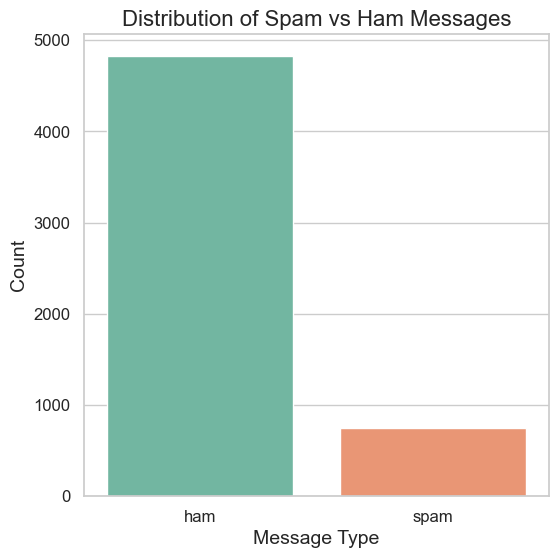

In [5]:
# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='v1', palette="Set2")
plt.title('Distribution of Spam vs Ham Messages', fontsize=16)
plt.xlabel('Message Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Identify target and text

In [6]:
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})
X_text = df['v2'].values
y = df['label'].values

In [7]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [8]:
X_text

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

# Stage I

### Clean the non-text (symbols, numbers...) characters and stopwords from the text data.

In [9]:
def clean_text(text):
    # Remove numbers and symbols, keep only letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Download stopwords if not done yet
nltk.download('stopwords')

# Apply cleaning
X_cleaned = [clean_text(text) for text in X_text]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sydyk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize the text

In [10]:
# Apply TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X_cleaned)

### Train the model

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.979372197309417
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



# Stage II

### Keras embedding + 1D ConvNet(CNN) model

#### Tokenize and Pad Sequences

In [12]:
y_cat = to_categorical(y)

In [13]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
X_seq = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Train test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [14]:
X_train

<4457x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 34104 stored elements in Compressed Sparse Row format>

#### Build CNN Model with Embedding

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Define model
model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile model
model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


#### Train the model

In [16]:
history_cnn = model_cnn.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=5,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1
)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8487 - loss: 0.3808 - val_accuracy: 0.9830 - val_loss: 0.0652
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9831 - loss: 0.0549 - val_accuracy: 0.9839 - val_loss: 0.0555
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9966 - loss: 0.0132 - val_accuracy: 0.9848 - val_loss: 0.0763
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9839 - val_loss: 0.0829
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9857 - val_loss: 0.0893


#### Evaluate

In [17]:

loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Test Accuracy (CNN): {accuracy * 100:.2f}%")

Test Accuracy (CNN): 98.57%


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix


# Get predicted probabilities
y_pred_proba = model_cnn.predict(X_test_cnn)
y_pred = model_cnn.predict(X_test_cnn).argmax(axis=1)

# Convert y_test (one-hot) back to binary labels
y_test_labels = y_test_cnn.argmax(axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [42]:
y_test_labels

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

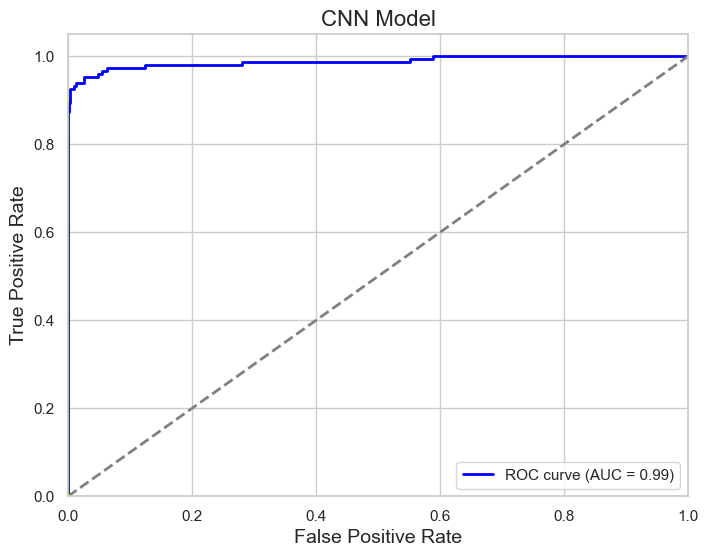

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('CNN Model', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

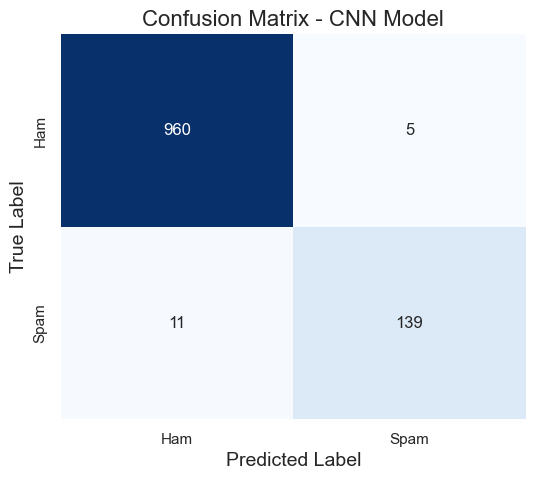

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - CNN Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Stage III

## BERT
The task says "using any DL model and **BERT Embedding** layers, develo a NLP model". 

In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

# Tokenize all texts
encoded_inputs = tokenizer(
    X_cleaned,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"  # Return PyTorch tensors
)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Convert labels to tensor
labels_tensor = torch.tensor(y.tolist())

# Create dataset
dataset = TensorDataset(encoded_inputs['input_ids'], 
                        encoded_inputs['attention_mask'], 
                        labels_tensor)

# Create dataloader
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=16)

In [24]:
from transformers import BertModel
import torch.nn as nn

class BERTClassifier(nn.Module):
    def __init__(self, num_labels=2):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("prajjwal1/bert-tiny")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output  # [CLS] token representation
        logits = self.classifier(cls_output)
        return logits


# Move model to device and rename to model_bert
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = BERTClassifier(num_labels=2).to(device)

In [25]:
optimizer = torch.optim.AdamW(model_bert.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [26]:
model_bert.train()
for epoch in range(3):  # Number of epochs
    print(f"Epoch {epoch + 1}")
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        optimizer.zero_grad()
        logits = model_bert(input_ids, attention_mask)  # Use model_bert
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Average Loss: {avg_loss:.4f}")

Epoch 1
Average Loss: 0.2454
Epoch 2
Average Loss: 0.0996
Epoch 3
Average Loss: 0.0745


In [27]:
from sklearn.metrics import accuracy_score

model_bert.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        logits = model_bert(input_ids, attention_mask)  # Use model_bert
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

Accuracy: 0.9873


## Comparing all models (model(randomForest), model_cnn, model_bert)

In [29]:
model_rf = model

In [30]:
rf_preds = model_rf.predict(X_test)
rf_proba = model_rf.predict_proba(X_test)[:, 1]  # for ROC AUC

In [43]:
cnn_preds = model_cnn.predict(X_test_cnn).argmax(axis=1)
cnn_proba = model_cnn.predict(X_test_cnn).argmax(axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [33]:
model_bert.eval()
bert_preds = []
bert_proba = []

with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        logits = model_bert(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        bert_preds.extend(preds)
        bert_proba.extend(probs)

In [34]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_proba)

    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    return acc, f1, roc_auc

--- Random Forest ---
Accuracy: 0.9794
F1 Score (Macro): 0.9526
ROC AUC: 0.9860



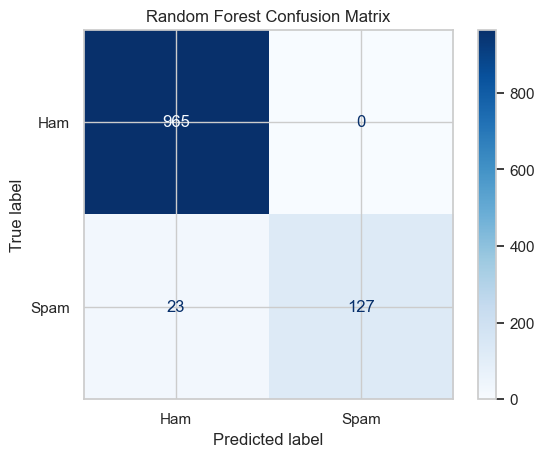

--- CNN ---
Accuracy: 0.9857
F1 Score (Macro): 0.9687
ROC AUC: 0.9607



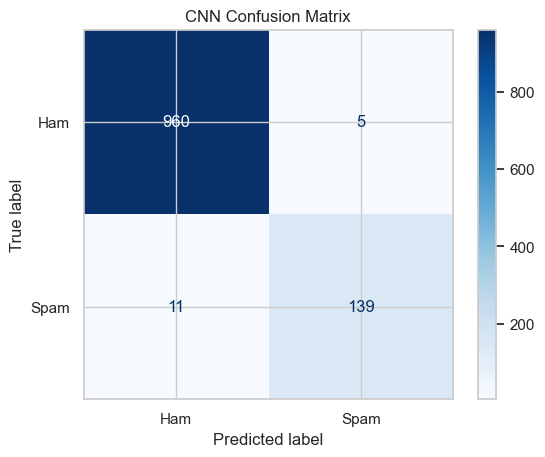

--- BERT ---
Accuracy: 0.7679
F1 Score (Macro): 0.4983
ROC AUC: 0.5117



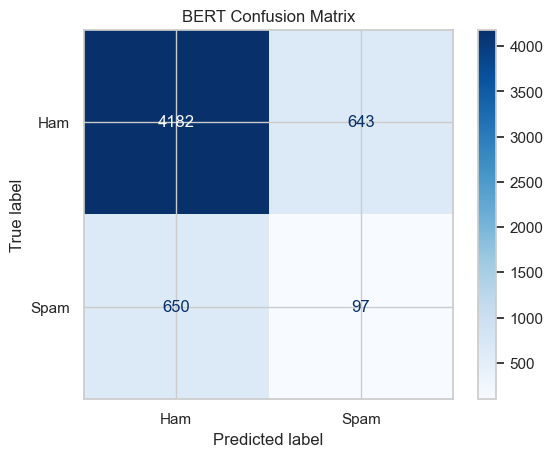

In [45]:
# Replace y_test with your actual test labels

rf_results = evaluate_model(y_test, rf_preds, rf_proba, "Random Forest")
cnn_results = evaluate_model(y_test_labels, cnn_preds, cnn_proba, "CNN")
bert_results = evaluate_model(y.tolist(), bert_preds, bert_proba, "BERT")

